Last update: 17th January, 2024

**Important Note:** You should have first uploaded the **entire** folder for Problem Sheet 1 to your Google Drive/ARC cluster. Note the path that leads to this directory!

You can then
- open this notebook with Google Colab through your drive (you are advised against opening this file directly in Google Colab), or
- follow the official ARC guide to open this notebook in ARC.

# Setup for Google Colab

> **Important: You should complete the following setups everytime if you have restarted a new runtime in Google Colab (e.g. switching from CPU to GPU and vice versa).**

**If you are running this notebook in Google Colab,** run the following cell to mount your Google drive to this notebook. The Google Drive will then ask for your permission to write in your drive. **You can skip this step if you are running this notebook in ARC.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

Run the following `cd` command to make sure that this notebook now runs in the desired repository we want. If you are doing this question in Google Colab, you should run
```
%cd drive/MyDrive/{replace this with your path of directory}
```

In [ ]:
%cd drive/MyDrive/{"replace this with your path of directory"}

# Setup for ARC
You should follow section 6 to start an interactive session in ARC with GPU access. In particular, **before running any of the codes**, you should load the following modules:

```
module load PyTorch/1.11.0-foss-2022a-CUDA-11.7.0
module load h5py/3.7.0-foss-2022a
module load tqdm/4.64.0-GCCcore-11.3.0
```


# Question 3/4: Classifying digits in the MNIST dataset

We would like to classify the digits from the MNIST dataset, with the data in the form $(x_i, y_i)$ with $x_i \in \mathbb{R}^d$ ($d=28\times 28 = 784$) being the image and $y_i \in \mathbb{R}^K$ ($K=10$) being the labels. Recall the architecture of a shallow (single-layer) fully-connected neural network: $f(x,\theta)$ for $\theta=(C,W,b^{(1)},b^{(2)})$, defined iteratively as
$$
\begin{aligned}
    Z &= Wx + b^{(1)} \in \mathbb{R}^{d_H} \\
    H_i &= \sigma(Z_i) \\
    f(x,\theta) &= F_{\mathsf{softmax}}(CH + b^{(2)}) \in \mathbb{R}^K,
\end{aligned}
$$
where $\sigma(\cdot)$ is an activation function to be specified, and that $d_H$ is the number of hidden units.

Before this, let us setup the environments for you. This is done by running the following cell.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
import h5py
from tqdm import tqdm
from random import randint
import random

# Load the class MNIST dataset.
Run the cell below to convert the dataset to the familiar `np.array` format.

> **If you are running the notebook in Google Colab and that the above setup fails**, you can upload the dataset (`MNISTdata.hdf5`) directly to the file explorer. Please consult [this tutorial](https://towardsdatascience.com/7-ways-to-load-external-data-into-google-colab-7ba73e7d5fc7) from the `towardsdatascience.com`.

In [2]:
MNIST_data = h5py.File('./MNISTdata.hdf5', 'r')
x_train = np.float32(MNIST_data['x_train'][:] )
y_train = np.int32(np.array(MNIST_data['y_train'][:,0]))
x_test = np.float32( MNIST_data['x_test'][:] )
y_test = np.int32( np.array( MNIST_data['y_test'][:,0]))

MNIST_data.close()

# Readme first: speeding up your computation by matrix multiplication and broadcasting

## Matrix Multiplication

The product of a matrix `W` and a vector `x` could be written as `W @ x`.

In [5]:
W = np.array([[1,2],[1,1]])
x = np.array([2,3])
W @ x

array([8, 5])

How about evaluating multiple matrix-vector multiplications? We may do that by using matrix-matrix multiplication. For instance, if we want to evaluate `W @ x1` and `W @ x2` for matrix `W` and vectors `x1, x2`, we could
- form `X = np.array([x1, x2]).T`,
- evaluate `W @ X`, then
- `W @ x1 = (W @ X).T[0]` and
- `W @ x2 = (W @ X).T[1]`.

**Warning:** In doing this, we need to be careful with our convention for dimensions.

In [6]:
W = np.array([[1,2],[1,3]])
x1 = np.array([2,3])
x2 = np.array([1,1])
X = np.array([x1,x2]).T
all(W @ x1 == (W @ X).T[0]), all(W @ x2 == (W @ X).T[1])

(True, True)

The reason for mentioning this is that, computing a matrix-matrix multiplication is much faster than looping many matrix-vector multiplication. This is often called *vectorisation*, and could significantly speed up the computation speed.

## Broadcasting
But how about computing `Wx + b` for multiple inputs `x = x1, x2, ...`? The `numpy` addition is capable of adding a matrix and a vector (as an 1-d array) together. But what does that even mean? Let us try it out with the example below.

In [7]:
C = np.array([[1,2],[1,3]])
b = np.array([2,3])
C + b

array([[3, 5],
       [3, 6]])

You will recognise that what addition of a matrix and an 1-d array really does is to compute the following
$$C + b = C + \begin{bmatrix} \leftarrow & b & \rightarrow \\ \leftarrow & b & \rightarrow \\ & \vdots & \\ \leftarrow & b & \rightarrow \end{bmatrix}.$$

A better illustration is provided in the [official `numpy` documentation](https://numpy.org/doc/stable/user/basics.broadcasting.html):

![Broadcasting](https://numpy.org/doc/stable/_images/broadcasting_2.png)

This powerful feature is very useful in avoiding for loops when computing `Wx+b` for multiple inputs. **A caveat would be to be careful with the direction of broadcasting!** From the above figure, we see that broadcasting updates rows instead of columns (as mathematician could have expected!) This is due to historical reasons that computer scientists believed that working with rows are more natural...

So what do we do if we want to compute `Wx + b` for multiple inputs `x = x1, x2, ...`, assuming `b` is an 1D array? We know that the rows of `(W @ X).T` (where `X = np.array([x1,x2,...]).T`) are the products `W @ x1, W @ x2, ...`, so we know that the rows of `(W @ X).T + b` are our desired inputs `W @ x1 + b, W @ x2 + b, ...`

In [8]:
W = np.array([[1,2],[1,3]])
x1 = np.array([2,3])
x2 = np.array([1,1])
b = np.array([.5, 1.5])
X = np.array([x1,x2]).T
all(W @ x1 + b == (W @ X).T[0] + b), all(W @ x2 + b == (W @ X).T[1] + b)

(True, True)

## I am super confused with the transpose!
So do I, and there isn't much we can do. Computer scientist would therefore instead adopt the following convention when writing out the neural network

$$f(x;C,W,b^{(1)},b^{(2)}) = F_{\mathsf{softmax}} (C \sigma.(xW+b^{(1)}) + b^{(2)}),$$

assuming $x, b^{(1)}, b^{(2)}$ are **ROW** vectors. I personally would like to stick with the math convention. To the end, you probably don't need to worry about this, as computer scientists have implemented neural networks in `PyTorch` anyway.

## Computing outer product
We note that in performing backpropagation, we need to compute outer product of the two vectors (as 1D array), sav `v` and `w`. This is taken care of by the `np.outer` function.

In [9]:
v = np.array([1,2])
w = np.array([2,3])
np.outer(v,w)

array([[2, 3],
       [4, 6]])

# Question 3 Part (b) - Implementing NN without PyTorch

By the time of reading this notebook, you should have completed **part (a)** of the problem sheet, and read through pages 28-37 of the lecture slides. In this part, you are asked to implement and train a fully-connected neural network with one hidden layer. You will first do this from scratch, before doing this again with PyTorch in question 4.

A neural network is defined as a `class` in Python. We will assume that you are familiar with working with class. If you need help, consult the following [W3school tutorial](https://www.w3schools.com/python/python_classes.asp).

Read the instructions in the problem sheet to implement and train a shallow neural network from scratch.

In [7]:
class myShallowNetwork:
  def __init__(self, num_inputs=784, num_outputs=10, num_hidden_units=200, sw=1, sb=1):
    self.num_inputs = num_inputs
    self.num_hidden_units = num_hidden_units
    self.num_outputs = num_outputs

    ### TODO (1): initialise the weights and biases. Your solutions goes here.   
    self.W1 = np.random.randn(num_hidden_units,num_inputs) / np.sqrt(num_inputs) # Random Init of W
    self.W2 = np.random.randn(num_outputs,num_hidden_units) / np.sqrt(num_hidden_units) # Random Init of C
    self.b1 = np.zeros((num_hidden_units, 1))
    self.b2 = np.zeros((num_outputs, 1))
    

  ### TODO (2): implement the hidden_function, softmax_function and hidden_function_grad.
  def hidden_function(self,z):
    # Sigmoid function 
    return 1 / (1 + np.exp(-z))

  def softmax_function(self, z):
    e_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return e_z / e_z.sum(axis=0, keepdims=True)

  def hidden_function_grad(self,z):
    # Find the gradient of sigmoid function
    return self.hidden_function(z) * (1 - self.hidden_function(z))



  ### TODO (3): implement the forward function (return two dimensional array)
  def forward(self,x):
    
    # Reshape x 
    if x.ndim == 1: 
        Z = self.W1 @ x.reshape(-1, 1) + self.b1
    else: 
        Z = self.W1 @ x + self.b1
        
    # Compute Z, H, U, f and Rho
    H = self.hidden_function(Z)
    U = self.W2 @ H + self.b2
    f = self.softmax_function(U)
    
    print("f shape", f.shape)

    return f, Z, H


  ### TODO (4): implement the backward function
  def backward(self,x,y): 
    
    # Run Forward Algorithm 
    f, Z, H = self.forward(x) 
    
    #creating one hot encoded matrix (2D) 
    encoded_array = np.zeros((self.num_outputs, y.size))
    encoded_array[y, np.arange(y.size),] = 1.0
    
    # Find gradients
    dU = f - encoded_array
    db2 = dU.reshape(-1,1)
    dW2 = dU @ H.T 
    delta = self.W2.T @ db2 # or dH
    db1 = delta * self.hidden_function_grad(Z)
    dW1 = np.outer(db1, x)  
    
    return dW1, dW2, db1, db2


  def train(self, x_train, y_train, LR=.01, num_epochs=1):
    time1 = time.time()

    ### TODO (5): implement the train function
    for epochs in range(num_epochs):

        # Section: implement the SGD
        for n in tqdm(range(len(x_train))): 
            
          # randomly select a data point (x, y)
          rand_index = randint(0,len(x_train)-1)
            
          x = x_train[rand_index] 
          y = y_train[rand_index]  

          # compute gradient with respect to cross-entropy loss
          dW1, dW2, db1, db2 = self.backward(x, y)
        
          # update weights and biases
          self.W2 -= LR * dW2
          self.b2 -= LR * db2
          self.W1 -= LR * dW1
          self.b1 -= LR * db1

        
        # Section: At the end of each epoch, compute the training accuracy

        # compute the probability vectors for each training inputs
        # It should be emphasised that p is a 2D array containing all predicted probability as vectors
        p, _, _ = self.forward(x_train.T)

        # compute the prediction - you don't need to do a for loop here!
        y_pred = np.argmax(p, axis = 0)

        # compute the number of correct predictions - you don't need to do a for loop here!
        total_correct = np.sum(y_pred == y_train)

        print(f"Train accuracy: {total_correct/len(x_train):.2f}")
        ### End of TODO (5)


    time2 = time.time()
    print(f"Training time is {time2-time1}s.")
    
    

  ### TODO (6): implement the predict function 
  def predict(self, x_test):
    p, _, _ = self.forward(x_test)
    y_pred = np.argmax(p, axis = 0)
    return y_pred
  ### End of TODO (6)

  def test(self, x_test, y_test, plot_confusion=False):
    ### TODO (7): implement the test function 
    y_pred = self.predict(x_test.T)
    total_correct = np.sum(y_pred == y_test)
    accuracy = total_correct/len(y_test)
    
    
    if plot_confusion:
        # Compute the confusion matrix
        confusion_matrix, _, _ = np.histogram2d(y_test, y_pred, bins=np.arange(self.num_outputs + 1))

        # Plotting the confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='viridis')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

    return accuracy

Congratulations in completing the To-dos. Before we actually train the neural network for classifying MNIST digits, let us compare our computed gradients with its finite-difference approximation.

In [8]:
my_SNN = myShallowNetwork()
my_SNN_new = myShallowNetwork()

# initialise our new network such that it has same parameters as the original network
my_SNN_new.W1 = my_SNN.W1.copy()
my_SNN_new.W2 = my_SNN.W2.copy()
my_SNN_new.b1 = my_SNN.b1.copy()
my_SNN_new.b2 = my_SNN.b2.copy()

# now perturb our parameters by a little bit,
# here we demonstrate an entry for the bias for the hidden layer
k = randint(0, my_SNN.num_hidden_units - 1)
epsilon = 1e-9
my_SNN_new.b1[k] += epsilon

# we may then compute an estimate of the derivative, and compare with the derivative computed from backpropagation
sample = randint(0,len(x_train)-1)
x_input = x_train[sample].reshape(my_SNN.num_inputs, -1) # Used to be [:], also swapped order on differential
y_input = y_train[sample]

differential = ((-np.log(my_SNN_new.forward(x_input)[0][y_input][0])) - (-np.log(my_SNN.forward(x_input)[0][y_input][0])))/epsilon


grad_W, grad_C, grad_b1, grad_b2 = my_SNN.backward(x_input, y_input)
print(f"absolute error of the derivative is {np.abs(differential - grad_b1[k])}")

f shape (10, 1)
f shape (10, 1)
f shape (10, 1)
absolute error of the derivative is [4.79147394e-07]


You may repeat the above procedure for different partial derivatives. Once you are convinced that the algorithm works, you can run the following cell to see how good our implementation of shallow neural network is.

In [5]:
my_SNN = myShallowNetwork()
my_SNN.train(x_train, y_train)

100%|███████████████████████████████████| 60000/60000 [00:44<00:00, 1358.43it/s]


Train accuracy: 0.92
Training time is 44.74578785896301s.


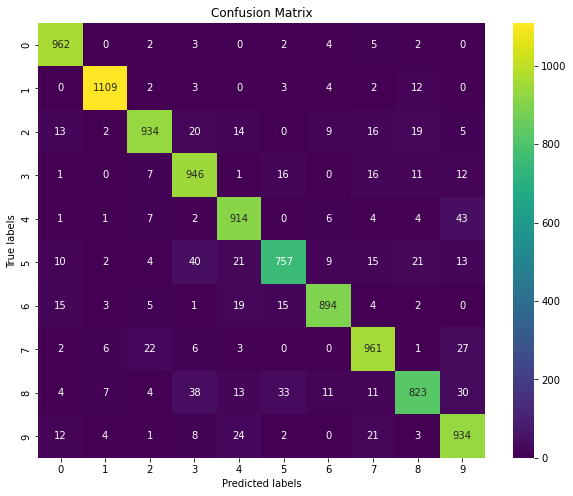

0.9234

In [6]:
my_SNN.test(x_test, y_test, plot_confusion=True)

# Question 4 - Implement NN with PyTorch

The question is designed for you to not only get used to the syntax of PyTorch, but also how to navigate with Python files in Google Colab and use the (free) GPU resources in Google Colab/ARC. Follow the following steps to complete your setup.

1. Make sure that the demonstration file `PyTorch_MultiLayer_MNIST.py` is in the same directory as this notebook in your Google Drive / ARC storage, as well as the dataset `MNISTdata.hdf5`.

> You can jump to step 4 if you are using ARC. Complete the following if you are using Google Colab.

2. Now go to `Runtime` and select `Change runtime type`. Once you are done, click save.

3. Since you have change your runtime, you have to setup your Google Colab. This involve mounting your Google drive and `cd`-ing to the correct directory.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive/{"replace this with your path of directory"}

4. Now run the following cell to enable `autoreload` which **allows code changes to be effective immediately**. Please <font color=red>**always**</font> run the code cell below each time before you attempt this question.

In [ ]:
# enable autoreload
%load_ext autoreload
%autoreload 2

5. Now run the following cell to run the demo file `PyTorch_MultiLayer_MNIST.py`. Notice how the training of the neural network is accelerated with the use of the GPU.

In [ ]:
%run ./PyTorch_MultiLayer_MNIST.py

**Important:** Remember to change the runtime type back to `None` to save your GPU credits!